In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


In [3]:
import tensorflow as tf
from datetime import datetime
import pandas as pd
from tqdm.autonotebook import tqdm
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from avgn.networks.test_datasets import load_fashion_MNIST
from avgn.networks.sample_networks import fc_net, conv_net

In [5]:
epochs = 100
latent_dim = 512
batch_size = 64
dims = (28 , 28, 1)

In [6]:
from tensorflow.keras.layers import (
    RepeatVector,
    Dense,
    TimeDistributed,
    Conv1D,
    Conv2D,
    Reshape,
    Bidirectional,
    concatenate,
    Input,
    UpSampling2D,
    MaxPooling2D,
)  # , LSTM
from tensorflow.python.keras.layers.recurrent import UnifiedLSTM as LSTM
from tensorflow.python.keras.layers.recurrent import UnifiedGRU as GRU
from tensorflow.keras import Model

In [7]:
def unet_convblock_down(
    _input,
    channels=16,
    kernel=(3, 3),
    activation="relu",
    pool_size=(2, 2),
    kernel_initializer="he_normal",
):
    conv = Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(_input)
    conv = Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(conv)
    pool = MaxPooling2D(pool_size=pool_size)(conv)
    return conv, pool

In [8]:
def unet_convblock_up(
    last_conv,
    cross_conv,
    channels=16,
    kernel=(3, 3),
    activation="relu",
    pool_size=(2, 2),
    kernel_initializer="he_normal",
):
    
    up_conv = UpSampling2D(size=(2, 2))(last_conv)
    merge = concatenate([up_conv, cross_conv], axis = 3)
    conv = Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(merge)
    conv = Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(conv)
    return conv

In [9]:
def unet_mnist():
    inputs = Input(shape=(28, 28, 1))
    up_1, pool_1 = unet_convblock_down(inputs, channels=32)
    up_2, pool_2 = unet_convblock_down(pool_1, channels=64)
    conv_middle = Conv2D(
        128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
    )(pool_2)
    conv_middle = Conv2D(
        128, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same"
    )(conv_middle)
    down_2 = unet_convblock_up(conv_middle, up_2, channels=64)
    down_1 = unet_convblock_up(down_2, up_1, channels=32)
    outputs = Conv2D(1, (1,1), activation="sigmoid")(down_1)
    return inputs, outputs

In [10]:
def plot_recon(example_data, nex = 3, zm = 2):
    z, xg, zi, xi, d_xi, d_x, d_xg = model.network_pass(example_data)
    fig, axs = plt.subplots(ncols=6, nrows = nex, figsize=(zm*6, zm*nex))
    for axi, (dat, lab) in enumerate(
        zip(
            [example_data, d_x, xg, d_xg, xi, d_xi],
            ["data", "disc data","gen", "disc gen", "interp", "disc interp"],
        )
    ):
        for ex in range(nex):
            axs[ex, axi].matshow(dat.numpy()[ex].squeeze(), cmap = plt.cm.Greys, vmin=0, vmax=1)
            axs[ex, axi].axis('off')
        axs[0, axi].set_title(lab)
        
    plt.show()

In [11]:
def plot_losses(losses):
    fig, axs = plt.subplots(ncols=5, figsize=(15,4))
    axs[0].semilogx(losses.D_prop.values, label='D_prop')
    axs[1].loglog(losses.d_xg_loss.values, label='d_xg_loss')
    axs[2].loglog(losses.d_xi_loss.values, label='d_xi_loss')
    axs[3].loglog(losses.d_x_loss.values, label='d_x_loss')
    axs[4].loglog(losses.xg_loss.values, label='xg_loss')
    for ax in axs.flatten():
        ax.legend()
    plt.show()

In [12]:
def test_losses(model, test_dataset, batch_size=512, TEST_BUF=1000):
    n_test = int(np.sum([True for i in test_dataset])*.9)
    test_loss = []
    tx = 0
    for test_x in tqdm(test_dataset, total=n_test, leave=False):
        test_loss.append(model.compute_loss(test_x))
        tx += 1
        if tx >=n_test:
            break
    D_prop,d_xg_loss, d_xi_loss, d_x_loss, xg_loss = np.mean(
        [[i.numpy() for i in row] for row in test_loss], axis=0
    )
    return D_prop, d_xg_loss, d_xi_loss, d_x_loss, xg_loss

In [13]:
network_arch = conv_net(dims=dims, n_Z = latent_dim)

In [14]:
# get the datasets
TRAIN_BUF = 60000
train_dataset, test_dataset = load_fashion_MNIST(BATCH_SIZE=batch_size, TRAIN_BUF=TRAIN_BUF)

In [19]:
from avgn.networks.gaia4 import GAIA

# prepare the optimizer
lrbase = 1e-3 # 1e-3
gen_optimizer = tf.keras.optimizers.Adam(lrbase, beta_1 = 0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(lrbase)
# train the model
model = GAIA(
    enc = network_arch.encoder,
    dec = network_arch.decoder,
    unet_function = unet_mnist,
    dims = dims, 
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    batch_size = batch_size,
    alpha = 0.75, #0.25
    lr = 1e-4
)

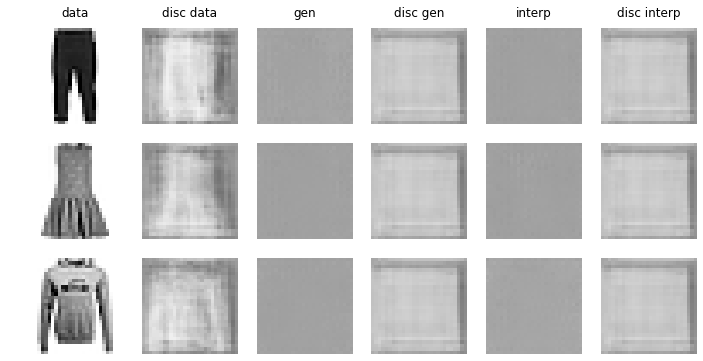

In [20]:
example_data = next(iter(train_dataset))
z = model.encode(example_data)
zi = model._interpolate_z(z)
d_x = model.discriminate(example_data)
plot_recon(example_data)

In [ ]:
losses = pd.DataFrame(columns=['D_prop', 'd_xg_loss', 'd_xi_loss', 'd_x_loss', 'xg_loss'])

Epoch 0


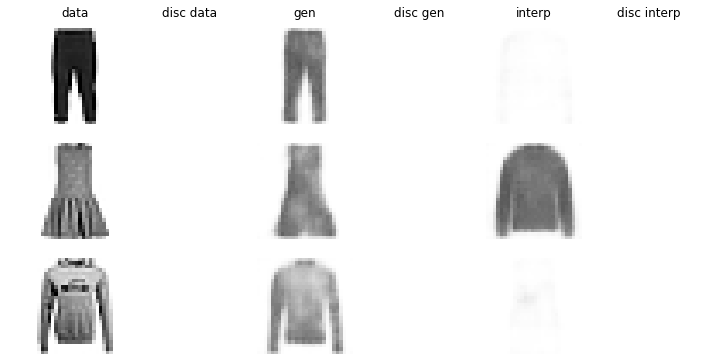

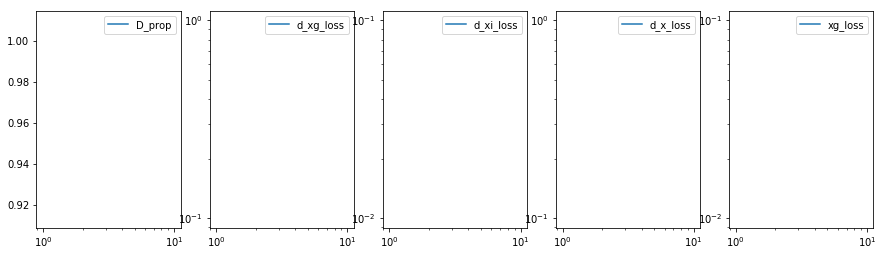

In [ ]:
for epoch in range(1000): 
    txi = 0
    for train_x in tqdm(train_dataset):
        if txi == int(TRAIN_BUF/batch_size)-1: continue
        try:
            model.train(train_x)
        except ValueError: 
            continue
        txi +=1
        
        #if txi % 100 == 0:
        #    print("Epoch {}".format(epoch))
        #    plot_recon(example_data)
        #    losses.loc[len(losses)] = test_losses(model, test_dataset, batch_size=batch_size)
        #    plot_losses(losses)
        #    plt.show()
    display.clear_output(wait=False)
    print("Epoch {}".format(epoch))
    plot_recon(example_data)
    losses.loc[len(losses)] = test_losses(model, test_dataset, batch_size=batch_size)
    plot_losses(losses)
    plt.show()

In [ ]:
tds = iter(train_dataset)
example_data = next(tds)
example_data = next(tds)


In [ ]:
z = model.encode(example_data)
zi = model._interpolate_z(z)
d_x = model.discriminate(example_data)
plot_recon(example_data)

In [ ]:
nx = 3000
fix, axs = plt.subplots(ncols = 4, figsize=(16,4))
for i, npts in enumerate([1, 10, 100, 100]):
    z = tf.random.normal(shape=(npts,nx))
    ip = tf.convert_to_tensor(
        #np.random.vonmises(size=(z.shape[0], z.shape[0]), mu = 1, kappa = 1),
        #np.random.uniform(size=(z.shape[0], z.shape[0])),
        np.random.chisquare(1/npts, size=(z.shape[0], z.shape[0])),
        dtype=tf.float32
    )
    ip = ip / tf.reduce_sum(ip, axis=0)
    zi = tf.transpose(tf.tensordot(tf.transpose(z), ip, axes=1))
    axs[i].hist(z.numpy().flatten(), alpha = 0.5);
    axs[i].hist(zi.numpy().flatten(), alpha = 0.5);